# VGG + DEEP CLUSTERING + BRAIN TUMOR

In [1]:
# ! pip install torch torchvision numpy pydantic interpret faiss-cpu torchsummary matplotlib pandas seaborn scikit-learn scikit-image pytorch-lightning[extra] --no-cache-dir --ignore-installed

In [1]:
import copy
import os
import pickle
import logging
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from data.brain_tumor_mri import BrainTumorMRI
from models.vgg_deep import DVGG
from pytorch_lightning import Trainer, seed_everything

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Timer
from pytorch_lightning.callbacks import RichProgressBar

from pytorch_lightning.loggers import CSVLogger
from torchvision import transforms
from torchvision.transforms import functional as F

from helpers.prediction import get_labels_from_prediction
from helpers.metrics import dmetrics_to_dataframe
from report.plots import plot_loss_curve, plot_acc_curve, plot_analysis, plot_clustering_metrics
from report import basic_report

seed_everything(42, workers=True)
pd.set_option('display.max_rows', None)

Global seed set to 42


In [3]:
BATCH_SIZE = 64
VAL_SIZE = 0.3
EPOCHS = 30
DATASET_RANDOM = 37

brain_tumor = BrainTumorMRI(val_size=VAL_SIZE, batch_size=BATCH_SIZE, random_state=DATASET_RANDOM, transformations=transforms.Compose(
            [
                transforms.Resize((255, 255)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        ))

# MODEL

In [4]:
model = DVGG(dataset=brain_tumor, num_classes=8, preprocessing=True, pca=64, freeze=False)

timer = Timer()
progress_bar = RichProgressBar()
logger = CSVLogger(save_dir="./", name=f"experiments-1/{model.name}", flush_logs_every_n_steps=1)
checkpoint_callback = ModelCheckpoint(
    filename=f"{model.name}-" + "{epoch}-{train_loss:.4f}-{train_acc:.4f}-{val_loss:.4f}-{val_acc:.4f}",
    save_top_k=3, save_last=True, monitor="val_loss", mode="min", verbose=True
)

trainer = Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=EPOCHS,
    logger=logger,
    callbacks=[timer, progress_bar, checkpoint_callback],
    log_every_n_steps=1,    
    # enable_progress_bar=False,
    # limit_train_batches=DATASET_RATIO or 1.0,
    # limit_val_batches=DATASET_RATIO or 1.0,
    # limit_test_batches=DATASET_RATIO or 1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## TRAINING

In [5]:
trainer.fit(
    model,
    train_dataloaders=brain_tumor.train_dataloader,
    val_dataloaders=brain_tumor.val_dataloader
)

┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss_fn   │ CrossEntropyLoss   │      0 │
│ 1 │ train_acc │ MulticlassAccuracy │      0 │
│ 2 │ val_acc   │ MulticlassAccuracy │      0 │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │
│ 4 │ model     │ VGG                │  134 M │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 134 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 134 M                                                                                                
Total estimated model params size (MB): 537

Output()

Epoch 0

Feature extracting elapsed time: 484.5065 seconds.

Pre-processing elapsed time: 0.9837 seconds.

/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/th
readpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(

Clustering elapsed time: 1.3133 seconds.

Epoch 0, global step 63: 'val_loss' reached 0.34966 (best 0.34966), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=0-train_loss=0.4721-train_acc=0.8344-val_loss=0.3497-val_acc=0.8821.ckpt' as top 3


Epoch 1

Creating dataset from Clustering elapsed time: 20.4861 seconds.

Feature extracting elapsed time: 523.4020 seconds.

Pre-processing elapsed time: 1.4934 seconds.

Clustering elapsed time: 2.2357 seconds.

Metrics: {'clu_homogeneity_score': 0.00272575465233917, 'clu_completeness_score': 0.002725960692351936, 
'clu_v_measure_score': 0.0027258576684520545, 'clu_adjusted_rand_score': -3.874721867515124e-05, 
'clu_adjusted_mutual_info_score': -0.00031052193361612415}

Epoch 1, global step 126: 'val_loss' reached 0.20893 (best 0.20893), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=1-train_loss=0.2745-train_acc=0.9137-val_loss=0.2089-val_acc=0.9358.ckpt' as top 3


Epoch 2

Creating dataset from Clustering elapsed time: 20.9273 seconds.

Feature extracting elapsed time: 516.3309 seconds.

Pre-processing elapsed time: 1.4949 seconds.

Clustering elapsed time: 1.9738 seconds.

Metrics: {'clu_homogeneity_score': 0.6832442319765848, 'clu_completeness_score': 0.676313124204521, 
'clu_v_measure_score': 0.6797610104817795, 'clu_adjusted_rand_score': 0.5930372278392793, 
'clu_adjusted_mutual_info_score': 0.6787910471714799}

Epoch 2, global step 189: 'val_loss' reached 0.11089 (best 0.11089), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=2-train_loss=0.1938-train_acc=0.9420-val_loss=0.1109-val_acc=0.9644.ckpt' as top 3


Epoch 3

Creating dataset from Clustering elapsed time: 20.2699 seconds.

Feature extracting elapsed time: 521.4797 seconds.

Pre-processing elapsed time: 1.4717 seconds.

Clustering elapsed time: 1.9056 seconds.

Metrics: {'clu_homogeneity_score': 0.7602109674887466, 'clu_completeness_score': 0.7649938092943097, 
'clu_v_measure_score': 0.762594889209751, 'clu_adjusted_rand_score': 0.7005161741534925, 
'clu_adjusted_mutual_info_score': 0.7618772922385604}

Epoch 3, global step 252: 'val_loss' reached 0.11436 (best 0.11089), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=3-train_loss=0.2165-train_acc=0.9425-val_loss=0.1144-val_acc=0.9650.ckpt' as top 3


Epoch 4

Creating dataset from Clustering elapsed time: 20.3343 seconds.

Feature extracting elapsed time: 511.7405 seconds.

Pre-processing elapsed time: 1.5318 seconds.

Clustering elapsed time: 1.9770 seconds.

Metrics: {'clu_homogeneity_score': 0.7787482439509804, 'clu_completeness_score': 0.778059911264481, 
'clu_v_measure_score': 0.7784039254368014, 'clu_adjusted_rand_score': 0.7240811888069112, 
'clu_adjusted_mutual_info_score': 0.7777322188584095}

Epoch 4, global step 315: 'val_loss' reached 0.08097 (best 0.08097), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=4-train_loss=0.1670-train_acc=0.9530-val_loss=0.0810-val_acc=0.9767.ckpt' as top 3


Epoch 5

Creating dataset from Clustering elapsed time: 20.4515 seconds.

Feature extracting elapsed time: 519.7514 seconds.

Pre-processing elapsed time: 1.3837 seconds.

Clustering elapsed time: 1.9829 seconds.

Metrics: {'clu_homogeneity_score': 0.7679933696167698, 'clu_completeness_score': 0.7768601743184875, 
'clu_v_measure_score': 0.7724013261168141, 'clu_adjusted_rand_score': 0.700623571780803, 
'clu_adjusted_mutual_info_score': 0.7717075891953143}

Epoch 5, global step 378: 'val_loss' was not in top 3


Epoch 6

Creating dataset from Clustering elapsed time: 21.3587 seconds.

Feature extracting elapsed time: 513.0329 seconds.

Pre-processing elapsed time: 1.5330 seconds.

Clustering elapsed time: 2.1087 seconds.

Metrics: {'clu_homogeneity_score': 0.7674336155633141, 'clu_completeness_score': 0.7576431225140066, 
'clu_v_measure_score': 0.7625069431596356, 'clu_adjusted_rand_score': 0.6829959359411114, 
'clu_adjusted_mutual_info_score': 0.761783613096249}

Epoch 6, global step 441: 'val_loss' reached 0.10679 (best 0.08097), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=6-train_loss=0.1788-train_acc=0.9472-val_loss=0.1068-val_acc=0.9650.ckpt' as top 3


Epoch 7

Creating dataset from Clustering elapsed time: 20.9974 seconds.

Feature extracting elapsed time: 533.5711 seconds.

Pre-processing elapsed time: 1.5463 seconds.

Clustering elapsed time: 2.0391 seconds.

Metrics: {'clu_homogeneity_score': 0.7440154142824743, 'clu_completeness_score': 0.7425804195492031, 
'clu_v_measure_score': 0.7432972243234616, 'clu_adjusted_rand_score': 0.6598037031212037, 
'clu_adjusted_mutual_info_score': 0.7425213881701758}

Epoch 7, global step 504: 'val_loss' reached 0.09033 (best 0.08097), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=7-train_loss=0.1157-train_acc=0.9690-val_loss=0.0903-val_acc=0.9848.ckpt' as top 3


Epoch 8

Creating dataset from Clustering elapsed time: 22.2415 seconds.

Feature extracting elapsed time: 577.5183 seconds.

Pre-processing elapsed time: 1.6810 seconds.

Clustering elapsed time: 2.1508 seconds.

Metrics: {'clu_homogeneity_score': 0.7512886553980396, 'clu_completeness_score': 0.7598788757017417, 
'clu_v_measure_score': 0.7555593500289944, 'clu_adjusted_rand_score': 0.6828005308427566, 
'clu_adjusted_mutual_info_score': 0.7548169540857121}

Epoch 8, global step 567: 'val_loss' reached 0.09745 (best 0.08097), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=8-train_loss=0.1648-train_acc=0.9592-val_loss=0.0975-val_acc=0.9737.ckpt' as top 3


Epoch 9

Creating dataset from Clustering elapsed time: 22.6320 seconds.

Feature extracting elapsed time: 573.2864 seconds.

Pre-processing elapsed time: 1.7517 seconds.

Clustering elapsed time: 2.5021 seconds.

Metrics: {'clu_homogeneity_score': 0.7549722902908794, 'clu_completeness_score': 0.7540626294557772, 
'clu_v_measure_score': 0.7545171856971564, 'clu_adjusted_rand_score': 0.6656632630660544, 
'clu_adjusted_mutual_info_score': 0.7537676402034952}

Epoch 9, global step 630: 'val_loss' was not in top 3


Epoch 10

Creating dataset from Clustering elapsed time: 24.3763 seconds.

Feature extracting elapsed time: 596.8625 seconds.

Pre-processing elapsed time: 1.7187 seconds.

Clustering elapsed time: 2.6306 seconds.

Metrics: {'clu_homogeneity_score': 0.7212099614472024, 'clu_completeness_score': 0.7205084268028222, 
'clu_v_measure_score': 0.7208590234429771, 'clu_adjusted_rand_score': 0.5915930525823324, 
'clu_adjusted_mutual_info_score': 0.7200075770991702}

Epoch 10, global step 693: 'val_loss' was not in top 3


Epoch 11

Creating dataset from Clustering elapsed time: 26.5798 seconds.

Feature extracting elapsed time: 607.4631 seconds.

Pre-processing elapsed time: 1.7564 seconds.

Clustering elapsed time: 2.2761 seconds.

Metrics: {'clu_homogeneity_score': 0.7200015681961112, 'clu_completeness_score': 0.7275293997601289, 
'clu_v_measure_score': 0.7237459098725186, 'clu_adjusted_rand_score': 0.6125637806660842, 
'clu_adjusted_mutual_info_score': 0.7228991376910912}

Epoch 11, global step 756: 'val_loss' was not in top 3


Epoch 12

Creating dataset from Clustering elapsed time: 24.7346 seconds.

Feature extracting elapsed time: 610.1394 seconds.

Pre-processing elapsed time: 1.7282 seconds.

Clustering elapsed time: 2.4604 seconds.

Metrics: {'clu_homogeneity_score': 0.7443417879365312, 'clu_completeness_score': 0.7361511961475735, 
'clu_v_measure_score': 0.7402238354693517, 'clu_adjusted_rand_score': 0.6546193612997394, 
'clu_adjusted_mutual_info_score': 0.739427915967663}

Epoch 12, global step 819: 'val_loss' reached 0.08253 (best 0.08097), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=12-train_loss=0.1013-train_acc=0.9692-val_loss=0.0825-val_acc=0.9854.ckpt' as top 3


Epoch 13

Creating dataset from Clustering elapsed time: 31.7604 seconds.

Feature extracting elapsed time: 747.3121 seconds.

Pre-processing elapsed time: 2.2677 seconds.

Clustering elapsed time: 3.5744 seconds.

Metrics: {'clu_homogeneity_score': 0.7553141822016244, 'clu_completeness_score': 0.7598837133848406, 
'clu_v_measure_score': 0.7575920574011276, 'clu_adjusted_rand_score': 0.673625663387352, 
'clu_adjusted_mutual_info_score': 0.7568512687714276}

Epoch 13, global step 882: 'val_loss' reached 0.06988 (best 0.06988), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=13-train_loss=0.1845-train_acc=0.9515-val_loss=0.0699-val_acc=0.9825.ckpt' as top 3


Epoch 14

Creating dataset from Clustering elapsed time: 29.0873 seconds.

Feature extracting elapsed time: 765.1451 seconds.

Pre-processing elapsed time: 2.2496 seconds.

Clustering elapsed time: 3.2222 seconds.

Metrics: {'clu_homogeneity_score': 0.7748917964979137, 'clu_completeness_score': 0.7684628362224571, 
'clu_v_measure_score': 0.7716639262004168, 'clu_adjusted_rand_score': 0.6874049599418188, 
'clu_adjusted_mutual_info_score': 0.7709669004717473}

Epoch 14, global step 945: 'val_loss' reached 0.07322 (best 0.06988), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=14-train_loss=0.2215-train_acc=0.9417-val_loss=0.0732-val_acc=0.9819.ckpt' as top 3


Epoch 15

Creating dataset from Clustering elapsed time: 35.6906 seconds.

Feature extracting elapsed time: 833.0202 seconds.

Pre-processing elapsed time: 2.4221 seconds.

Clustering elapsed time: 3.7446 seconds.

Metrics: {'clu_homogeneity_score': 0.7626662800147993, 'clu_completeness_score': 0.7606536034517932, 
'clu_v_measure_score': 0.7616586121153377, 'clu_adjusted_rand_score': 0.6742591534661936, 
'clu_adjusted_mutual_info_score': 0.7609351780059528}

Epoch 15, global step 1008: 'val_loss' was not in top 3


Epoch 16

Creating dataset from Clustering elapsed time: 30.4913 seconds.

Feature extracting elapsed time: 783.8228 seconds.

Pre-processing elapsed time: 2.4461 seconds.

Clustering elapsed time: 3.2708 seconds.

Metrics: {'clu_homogeneity_score': 0.7472855392277931, 'clu_completeness_score': 0.7618105077485612, 
'clu_v_measure_score': 0.754478122466651, 'clu_adjusted_rand_score': 0.6745000432462184, 
'clu_adjusted_mutual_info_score': 0.753726508786452}

Epoch 16, global step 1071: 'val_loss' was not in top 3


Epoch 17

Creating dataset from Clustering elapsed time: 32.5824 seconds.

Feature extracting elapsed time: 795.8567 seconds.

Pre-processing elapsed time: 2.3066 seconds.

Clustering elapsed time: 3.2262 seconds.

Metrics: {'clu_homogeneity_score': 0.7527686733139404, 'clu_completeness_score': 0.739435220547341, 
'clu_v_measure_score': 0.7460423770007503, 'clu_adjusted_rand_score': 0.6443787814118113, 
'clu_adjusted_mutual_info_score': 0.7452643796485634}

Epoch 17, global step 1134: 'val_loss' was not in top 3


Epoch 18

Creating dataset from Clustering elapsed time: 32.2903 seconds.

Feature extracting elapsed time: 798.3844 seconds.

Pre-processing elapsed time: 2.3013 seconds.

Clustering elapsed time: 2.8348 seconds.

Metrics: {'clu_homogeneity_score': 0.7491129505380452, 'clu_completeness_score': 0.7533619795210863, 
'clu_v_measure_score': 0.7512314568603319, 'clu_adjusted_rand_score': 0.6386605107499688, 
'clu_adjusted_mutual_info_score': 0.7504740425284508}

Epoch 18, global step 1197: 'val_loss' was not in top 3


Epoch 19

Creating dataset from Clustering elapsed time: 37.7566 seconds.

Feature extracting elapsed time: 1032.5221 seconds.

Pre-processing elapsed time: 2.4493 seconds.

Clustering elapsed time: 3.8791 seconds.

Metrics: {'clu_homogeneity_score': 0.7556081385087083, 'clu_completeness_score': 0.752181319695552, 
'clu_v_measure_score': 0.7538908349618991, 'clu_adjusted_rand_score': 0.6733254924460772, 
'clu_adjusted_mutual_info_score': 0.7531410343842392}

Epoch 19, global step 1260: 'val_loss' reached 0.07050 (best 0.06988), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=19-train_loss=0.3491-train_acc=0.9167-val_loss=0.0705-val_acc=0.9784.ckpt' as top 3


Epoch 20

Creating dataset from Clustering elapsed time: 29.3973 seconds.

Feature extracting elapsed time: 830.6725 seconds.

Pre-processing elapsed time: 2.3894 seconds.

Clustering elapsed time: 3.3437 seconds.

Metrics: {'clu_homogeneity_score': 0.722115318863802, 'clu_completeness_score': 0.7242093628250289, 
'clu_v_measure_score': 0.7231608249261133, 'clu_adjusted_rand_score': 0.5955248240627882, 
'clu_adjusted_mutual_info_score': 0.7223182627846083}

Epoch 20, global step 1323: 'val_loss' was not in top 3


Epoch 21

Creating dataset from Clustering elapsed time: 31.1614 seconds.

Feature extracting elapsed time: 698.1629 seconds.

Pre-processing elapsed time: 1.9801 seconds.

Clustering elapsed time: 2.5938 seconds.

Metrics: {'clu_homogeneity_score': 0.7461371032951596, 'clu_completeness_score': 0.7379047976204798, 
'clu_v_measure_score': 0.7419981172559136, 'clu_adjusted_rand_score': 0.6341664665541682, 
'clu_adjusted_mutual_info_score': 0.7412162896701812}

Epoch 21, global step 1386: 'val_loss' was not in top 3


Epoch 22

Creating dataset from Clustering elapsed time: 29.7425 seconds.

Feature extracting elapsed time: 757.6005 seconds.

Pre-processing elapsed time: 2.0862 seconds.

Clustering elapsed time: 3.0741 seconds.

Metrics: {'clu_homogeneity_score': 0.7321758314696284, 'clu_completeness_score': 0.7351922469090939, 
'clu_v_measure_score': 0.7336809388213494, 'clu_adjusted_rand_score': 0.6103945958166862, 
'clu_adjusted_mutual_info_score': 0.7328767775827366}

Epoch 22, global step 1449: 'val_loss' was not in top 3


Epoch 23

Creating dataset from Clustering elapsed time: 28.4751 seconds.

Feature extracting elapsed time: 721.5104 seconds.

Pre-processing elapsed time: 1.8703 seconds.

Clustering elapsed time: 3.2391 seconds.

Metrics: {'clu_homogeneity_score': 0.7475257858596625, 'clu_completeness_score': 0.7562882464855984, 
'clu_v_measure_score': 0.7518814875119817, 'clu_adjusted_rand_score': 0.643409063649991, 
'clu_adjusted_mutual_info_score': 0.7511260150708998}

Epoch 23, global step 1512: 'val_loss' reached 0.05131 (best 0.05131), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=23-train_loss=0.2284-train_acc=0.9385-val_loss=0.0513-val_acc=0.9877.ckpt' as top 3


Epoch 24

Creating dataset from Clustering elapsed time: 26.1473 seconds.

Feature extracting elapsed time: 657.1703 seconds.

Pre-processing elapsed time: 1.8182 seconds.

Clustering elapsed time: 2.9967 seconds.

Metrics: {'clu_homogeneity_score': 0.7706144156548572, 'clu_completeness_score': 0.7639294295222131, 
'clu_v_measure_score': 0.767257361571027, 'clu_adjusted_rand_score': 0.677719376865344, 
'clu_adjusted_mutual_info_score': 0.7665475784008602}

Epoch 24, global step 1575: 'val_loss' was not in top 3


Epoch 25

Creating dataset from Clustering elapsed time: 24.0445 seconds.

Feature extracting elapsed time: 592.6157 seconds.

Pre-processing elapsed time: 1.5734 seconds.

Clustering elapsed time: 2.0371 seconds.

Metrics: {'clu_homogeneity_score': 0.7394627548558642, 'clu_completeness_score': 0.7707308223367765, 
'clu_v_measure_score': 0.7547730910059066, 'clu_adjusted_rand_score': 0.5990233940477138, 
'clu_adjusted_mutual_info_score': 0.7540124744706864}

Epoch 25, global step 1638: 'val_loss' was not in top 3


Epoch 26

Creating dataset from Clustering elapsed time: 22.8733 seconds.

Feature extracting elapsed time: 564.7771 seconds.

Pre-processing elapsed time: 1.6104 seconds.

Clustering elapsed time: 2.7648 seconds.

Metrics: {'clu_homogeneity_score': 0.7700597815433281, 'clu_completeness_score': 0.7365337812693238, 
'clu_v_measure_score': 0.7529237568819566, 'clu_adjusted_rand_score': 0.603025398078843, 
'clu_adjusted_mutual_info_score': 0.752158799197294}

Epoch 26, global step 1701: 'val_loss' reached 0.06055 (best 0.05131), saving model to './experiments-1/dvgg/version_1/checkpoints/dvgg-epoch=26-train_loss=0.1616-train_acc=0.9647-val_loss=0.0605-val_acc=0.9866.ckpt' as top 3


Epoch 27

Creating dataset from Clustering elapsed time: 23.7977 seconds.

Feature extracting elapsed time: 568.0012 seconds.

Pre-processing elapsed time: 1.6280 seconds.

Clustering elapsed time: 2.6232 seconds.

Metrics: {'clu_homogeneity_score': 0.7387191827287426, 'clu_completeness_score': 0.74141320294264, 
'clu_v_measure_score': 0.7400637411141483, 'clu_adjusted_rand_score': 0.6121743068063994, 
'clu_adjusted_mutual_info_score': 0.7392758661767257}

Epoch 27, global step 1764: 'val_loss' was not in top 3


Epoch 28

Creating dataset from Clustering elapsed time: 26.4356 seconds.

Feature extracting elapsed time: 657.6613 seconds.

Pre-processing elapsed time: 1.5673 seconds.

Clustering elapsed time: 2.3137 seconds.

Metrics: {'clu_homogeneity_score': 0.7358634355722827, 'clu_completeness_score': 0.7444772642757966, 
'clu_v_measure_score': 0.7401452887861066, 'clu_adjusted_rand_score': 0.6366888399834558, 
'clu_adjusted_mutual_info_score': 0.7393513705372058}

Epoch 28, global step 1827: 'val_loss' was not in top 3


Epoch 29

Creating dataset from Clustering elapsed time: 23.3162 seconds.

Feature extracting elapsed time: 582.4245 seconds.

Pre-processing elapsed time: 1.4613 seconds.

Clustering elapsed time: 2.0343 seconds.

Metrics: {'clu_homogeneity_score': 0.733361319849092, 'clu_completeness_score': 0.721464995524959, 
'clu_v_measure_score': 0.7273645187082933, 'clu_adjusted_rand_score': 0.6127262077339407, 
'clu_adjusted_mutual_info_score': 0.7265336565827292}

Epoch 29, global step 1890: 'val_loss' was not in top 3
`Trainer.fit` stopped: `max_epochs=30` reached.


In [6]:
with open(f"{trainer.logger.log_dir}/{model.name}-timing.dump", "wb") as f:
    pickle.dump(model.timers, f)

In [7]:
with open(f"{trainer.logger.log_dir}/{model.name}-original-targets.dump", "wb") as f:
    pickle.dump(model.original_train_targets, f)

## TESTING

In [8]:
batch_predictions = trainer.predict(model, dataloaders=brain_tumor.test_dataloader)
truth_labels, preds_labels = get_labels_from_prediction(batch_predictions)
with open(f"{trainer.logger.log_dir}/{model.name}-preds.dump", "wb") as f:
    pickle.dump([truth_labels, preds_labels], f)

Output()

In [9]:
from collections import Counter

In [10]:
Counter(truth_labels)

Counter({2: 405, 1: 306, 0: 300, 3: 300})

In [11]:
Counter(preds_labels)

Counter({2: 409, 1: 305, 0: 301, 3: 296})

In [16]:
trainer.logger.log_dir

'./experiments-1/dvgg/version_1'

## ANALYSIS

In [12]:
train_metrics, valid_metrics, epoch_metrics, clustering_metrics = dmetrics_to_dataframe(f"{trainer.logger.log_dir}/metrics.csv", brain_tumor)

/Users/arthuralvim/Work/xai-clustering/helpers/metrics.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  metrics["epoch"] = metrics["epoch"].fillna(method="ffill")
/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


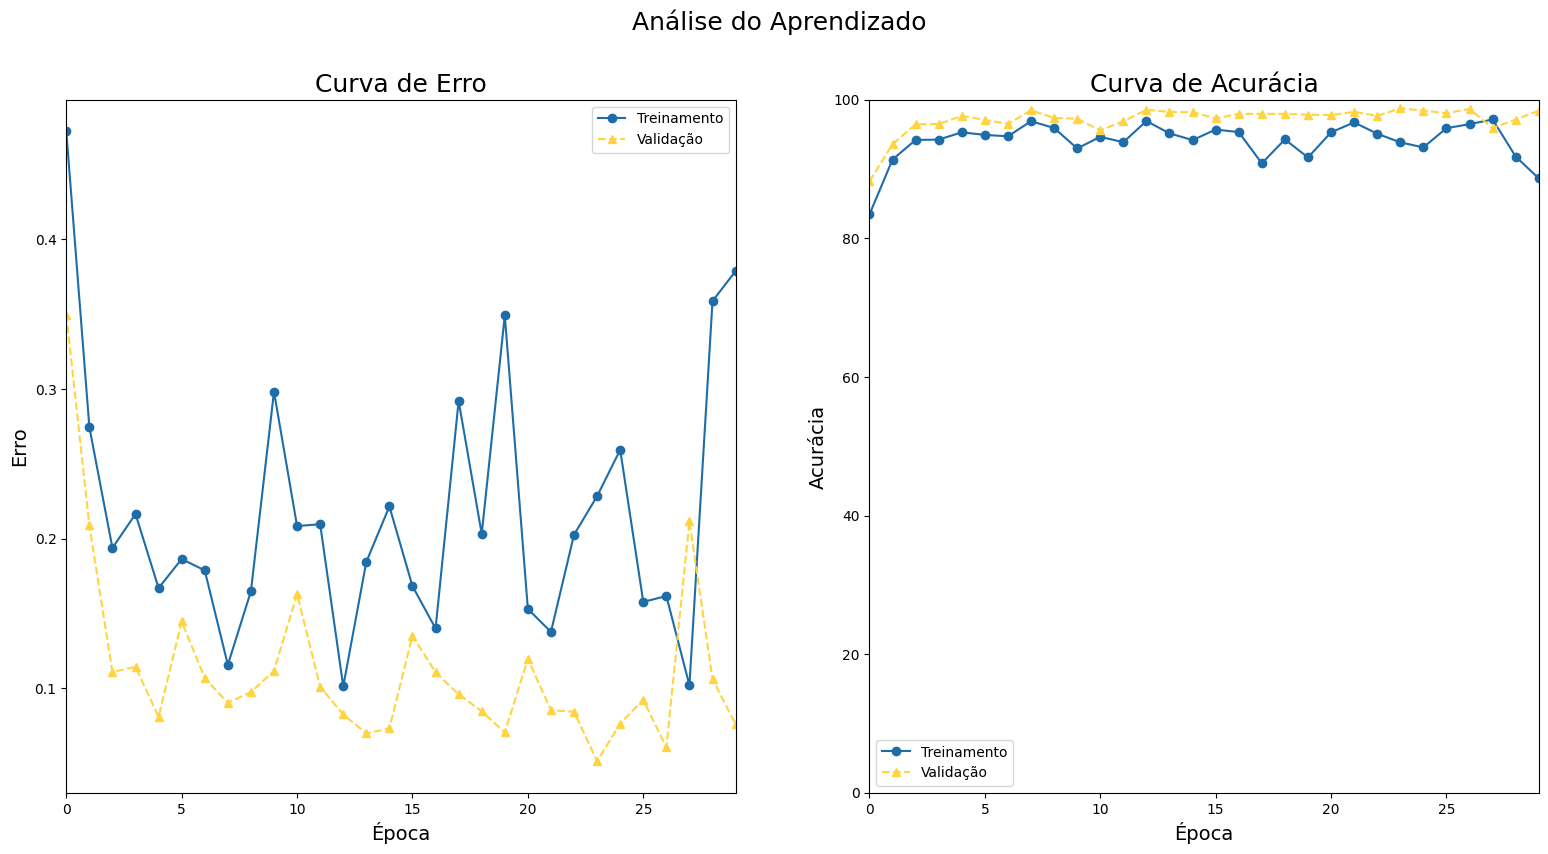

In [13]:
plot_analysis(epoch_metrics, save_as=f"{trainer.logger.log_dir}/{model.name}-analysis.png")

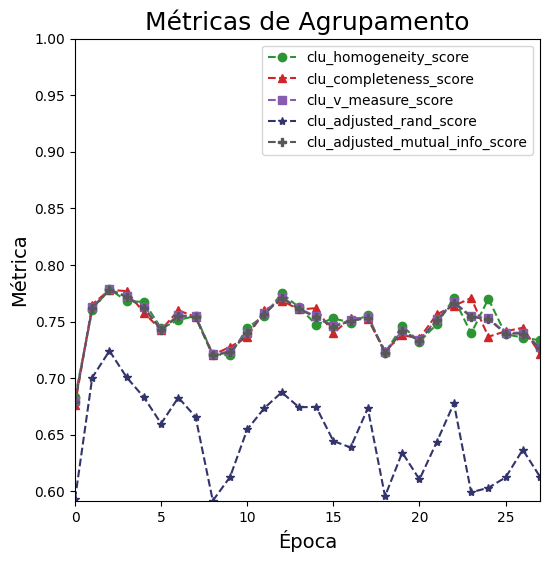

In [14]:
plot_clustering_metrics(clustering_metrics[1:], show=True, save_as=f"{trainer.logger.log_dir}/{model.name}-clustering.png")

In [15]:
plot_loss_curve(epoch_metrics, show=False, save_as=f"{trainer.logger.log_dir}/{model.name}-loss.png")
plot_acc_curve(epoch_metrics, show=False, save_as=f"{trainer.logger.log_dir}/{model.name}-acc.png")
basic_report(truth_labels, preds_labels, labels=[0,1,2,3], label_names=["Glioma", "Meningioma", "Sem Tumor", "Pituitária"], show=False, 
             save_as=f"{trainer.logger.log_dir}/{model.name}-confusion-matrix.png")

              precision    recall  f1-score   support

      Glioma      0.987     0.990     0.988       300
  Meningioma      0.977     0.974     0.975       306
   Sem Tumor      0.990     1.000     0.995       405
  Pituitária      1.000     0.987     0.993       300

    accuracy                          0.989      1311
   macro avg      0.988     0.988     0.988      1311
weighted avg      0.989     0.989     0.989      1311

            Gli  Men  Sem  Pit
Glioma      297    3    0    0
Meningioma    4  298    4    0
Sem Tumor     0    0  405    0
Pituitária    0    4    0  296
